# Kalman Filter
The Kalman Filter is used to reduce errors in measurements (observable states) and estimate non measureable system parameters (hidden states). The condition is that those parameters can be describe with a mathmatical model.[wiki](https://de.wikipedia.org/wiki/Kalman-Filter). 
In Kalman filters, we iterate measurement(measurement update) and motion (prediction). And the update will use Bayes rule, which is nothing else but a product or a multiplication. In prediction, we use total probability which is a convolution or simply an addition.

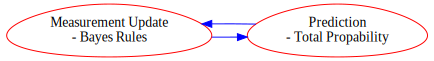

In [1]:
from graphviz import Digraph
g = Digraph('unix')

g.attr(rankdir='LR')
g.node('Measure', label= 'Measurement Update \n- Bayes Rules',color='red', shape= 'egg')
g.node('Predict',label= 'Prediction \n - Total Propability', color='red', shape='egg')
g.edge('Measure', 'Predict', color= 'blue')
g.edge('Predict','Measure', color= 'blue')
g

## Measurement Update 
We allready figure out that our position follows ad normal distribution (see introduction). Se we have an uncertainty of our current position $P(x)$. Once we measure $P(Z)$ me estimate a new position with an new covariance. So the conditional propability of this event is $P_X(Z)$. But what we are interestet in is, the probability of our current position based on the measurement $P_Z(X)$.
<br>
Thats the point where bayes rules comes in play....
$P_Z(X) = \frac{P_X(Z) *P(X)}{P(Z)}$ <br>
<br>
The calculation of the new mean is done by the weighted mean (gewichteter mittelwert):<br>
....

<br>
and the variance is calc as:
$\frac{1}{\sigma_{ab}}=\frac{1}{\sigma_{a}}+\frac{1}{\sigma_{b}}$



In [2]:
def gauss(x,mu,sigma):
    return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2) )

def weighted_mean(x1,sigma1, x2, sigma2):
    sumOfSigma = sigma1+sigma2
    return (x1*sigma1 + x2*sigma2)/sumOfSigma

def resVariance(sigma1, sigma2):
    return 1./(1./sigma1 +1./sigma2)

def update(x1,sigma1, x2, sigma2):
    mean = weighted_mean(x1,sigma1, x2, sigma2)
    var = resVariance(sigma1, sigma2)
    return [mean, var]

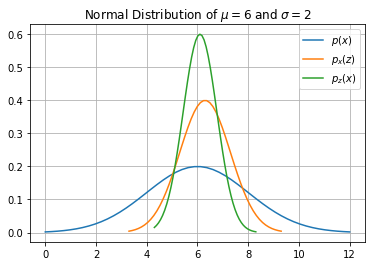

In [3]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

mu = 6 
sigma = 2

# prio distribution of our position 
x = np.linspace(mu-3*sigma,mu+3*sigma)
y = gauss(x,mu,sigma)
label ='$p(x)$'
plt.plot(x,y, label=label) # plot the gaussian distribution 

#  measurement p_x(z) with a better covariance 
mu_1 = 6.3 
sigma_1 = 1
x = np.linspace(mu_1-3*sigma_1,mu_1+3*sigma_1)
y = gauss(x,mu_1,sigma_1)
label ='$p_x(z)$'
plt.plot(x,y, label=label) # plot the gaussian distribution 

# updated mean and variance 
mu_2, sigma_2 = update(mu, sigma, mu_1, sigma_1)
x = np.linspace(mu_1-3*sigma_2,mu_1+3*sigma_2)
y = gauss(x,mu_2,sigma_2)
label ='$p_z(x)$'
plt.plot(x,y, label=label) # plot the gaussian distribution 


plt.grid(True)
title = ('Normal Distribution of $\mu = {} $ and $\sigma={}$').format(mu,sigma)
plt.title(title)
plt.legend()

## Prediction Step 
For the prediction we need a mathmatical description of a model.Assuming we have car which drives in one direction (x) with a constant velocity (cv).
The new mean, is your old mean plus the motion often $u$. So, if your car moves 10 m/s in x direction and your prediction step is 1s, your new new mean is:<br>
$x' = x + \dot{x}*dt$<br>
and the new variance is <br>
$\sigma' = \sigma + \sigma_{motion}$
<br>


In [4]:
def predict(mu1,var1,mu2,var2):
    return [mu1+mu2, var1+var2]

Lets try those equations with an example. Thereby the motion already includes the $ velocity * \delta t $. The initial $\sigma_{init}$ is choosen with 1000, the $\sigma_{motion} = 2.$ and $\sigma_{measurement} = 4.$.   


In [6]:

measurements = [5., 6., 7., 9., 10.]
motion = [1., 1., 2., 1., 1.]
measurement_sig = 4.
motion_sig = 2.
mu = 0.
sig = 10000.

#Please print out ONLY the final values of the mean
#and the variance in a list [mu, sig].
# update(mean1, var1, mean2, var2):

for index,m in enumerate(zip(measurements,motion)):
    mu,sig = update(mu,sig,m[0],measurement_sig )
    
    mu,sig = predict(mu,sig,m[1],motion_sig)
    print('Step ',index, ' Predicted pos:',mu, 'and variance:', sig)


Step  0  Predicted pos: 1.001999200319872 and variance: 5.998400639744102
Step  1  Predicted pos: 4.0015193154922315 and variance: 4.399744061425258
Step  2  Predicted pos: 7.429410766746279 and variance: 4.09518005751176
Step  3  Predicted pos: 9.205472187046041 and variance: 4.023515241621696
Step  4  Predicted pos: 10.601571796270873 and variance: 4.005861580844194


## Design Kalman Filter

For design a kalman filter we need two things:
* For the state we need a state transition matrix 
$ F = \begin{bmatrix} 1 & \delta t \\ 0 & 1 \end{bmatrix} $
<br> The new state is calculate by <br>
$ \begin{bmatrix} x' \\ \dot{x}' \end{bmatrix} = F * \begin{bmatrix} x \\ \dot{x} \end{bmatrix}$

* For the measurement we need a measurement matrix 
$H = \begin{bmatrix} 1,  0  \end{bmatrix}$ <br>
$ z = H * \begin{bmatrix} x \\ \dot{x} \end{bmatrix}$

<br>

### Final Design :
#### Pediction
$x' = F*x +u \\
P' = F*P*F^T $
#### Measurement Update:
$y = z-H*x \\
S= H*P*H^T + R \\
K= P*H^T*S^{-1} \\
x'=x+(K*y) \\
P'=(I-K*H)*P $

$x$ = estimate) <br>
$P$ = uncertainty covariance <br>
$F$ = state transition matrix <br>
$u$ = motion vector <br>
$z$ = measurement <br>
$H$ = measurement matrix <br>
$R$ = measurement noise <br>
$I$ = Identity matrix <br>



In [1]:
# Implement the filter function below
import numpy as np 

def kalman_filter(x, P):
    for n in range(len(measurements)):
        # measurement update
        Z =np.matrix([[measurements[n]]]) # that was thee hardest part :)
        ## Todo
        # update 
        
        # prediction

        pass
    return x,P

############################################
### use the code below to test your filter!
############################################
measurements = [1, 2, 3]

x = np.matrix([[0.], [0.]]) # initial state (location and velocity)
P = np.matrix([[1000., 0.], [0., 1000.]]) # initial uncertainty
u = np.matrix([[0.], [0.]]) # external motion
F = np.matrix([[1., 1.], [0, 1.]]) # next state function
H = np.matrix([[1., 0.]]) # measurement function
R = np.matrix([[1.]]) # measurement uncertainty
I = np.matrix([[1., 0.], [0., 1.]]) # identity matrix
state, Covariance =kalman_filter(x, P)
print('Final Position x : {} \nFinal Uncertainty P:\n{}').format(np.squeeze(state), Covariance)

Final Position x : [[0. 0.]] 
Final Uncertainty P:
[[1000.    0.]
 [   0. 1000.]]


## 1D Kalman for reducing errors
### Example Data 
The following example shows the measurement of a distance over a time intervall.


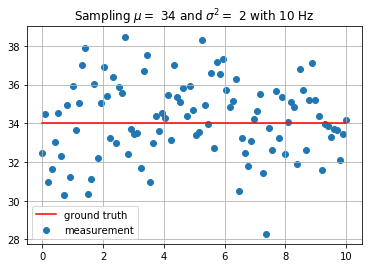

In [3]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
# Sample we 10 Hz 
rate = 10 # [Hz]
time = 10 # [s]
t = np.linspace(0,time,time*rate )
# mean and uncertainty of our measurment:
sigma = 2
mean = 34 
samples = np.random.normal(mean, sigma, rate*time) # creates samples 
_title = ('Sampling $\mu=$ {} and $\sigma^2=$ {} with {} Hz').format(mean,sigma,rate)
plt.scatter(t,samples, label = 'measurement')
plt.plot(t,np.ones(len(t))*mean, color='red', label= 'ground truth')
plt.title(_title)
plt.grid(True)
plt.legend()

The measurement uncertainty is defined as $R$ which is synonymical to the varianace $\sigma^2$. We define a estimated uncertainty as $P$. 
### Kalman Gain 1D 
The Kalman Gain equation in 1D is defined as follow:<br>
$K_n = \frac{P}{P + R}  = \frac{P_{n,n-1}}{P_{n,n-1}+R_n}\\ [0\leq K_n \leq 1] $
$P_{n,n-1}$ : is the extrapolated estimate uncertainty
$R_n$ : is the measurement uncertainty

### State Update :
The state update equation is defined as follows: 
<br>
$\hat{x}_{n,n}= \hat{x}_{n,n−1}+K_n(y_n−\hat{x}_{n,n−1})=(1−K_n)*\hat{x}_{n,n−1}+K_ny_n$ <br>
So the Kalman Gain $K$ is the weight that we give to the measurement and $(1-K_n)$ is the weight we apply to the estimate.

**Question:** How is the Kalman Gain correlated to the measurement and the estimation? <br>

**Answer:**
When the measurement uncertainty is very large and the estimate uncertainty is very small, the Kalman Gain is .......... Hence we give a big ....... to the estimate and a ....... weight to the measurement.

On the other side, when the measurement uncertainty is ........ and the estimate uncertainty is ........., the Kalman Gain is very s is ........ Hence we give a ...... weight to the estimate and a ......weight to the measurement.

If the measurement uncertainty is equal to the estimate uncertainty, then the Kalman gain equals to 0.5. 

#### Update the uncertainty 
This step is also known as the ***Covariance Update Equation***
<br>
$P_{n,n}= (1−K_n)P_{n,n−1}$

### Predict 
#### Extrapolate uncertainty 
At this point we normaly use the dynamic model equations. For our example the dynamic model is constant, so the estimate uncertainty extrapolation is <br>
$P_{n,n-1}=P_{n-1,n-1}$

### Putting all together

In [4]:
P = 1000.
P_plot=np.zeros(len(samples))
R = sigma 
x_pred = np.zeros(len(samples))
for index, s in enumerate(samples):
    if index == 0:
        x = s # use the first measurement for initialsation 
    ## Update
    # Kalman Gain 

    # Estimate the state

    # Update extrapolated uncertainty P

    
    ## Predict - static since we have no dynamic model 
    x = x 
    P = P 
    P_plot[index] = P # save P for plot 
    x_pred[index] = x


    

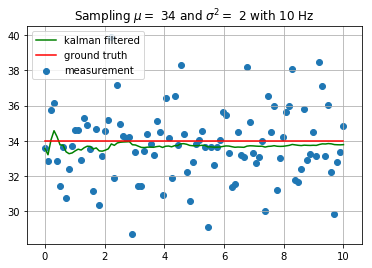

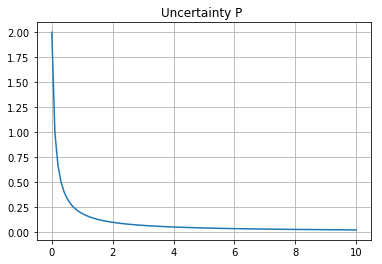

In [15]:
## Plot all results 

plt.plot(t,x_pred,color = 'green',label= 'kalman filtered')
plt.scatter(t,samples, label = 'measurement')
plt.plot(t,np.ones(len(t))*mean, color='red', label= 'ground truth')
plt.title(_title)
plt.grid(True)
plt.legend()
plt.figure()
plt.plot(t,P_plot)
plt.title('Uncertainty P ')
plt.grid(True)

## Kalman for moving objects (Multi Dimension)  
Using Radar Data as example thereby the radar estimates the postion and velocity of an object. 
Our state is defined <br>
$ \overline{x} = \begin{bmatrix} x \\ y \\ \dot{x} \\ \dot{y} \end{bmatrix}$

We can easily write down our dynamic model as follows: <br>
$ x_x = x_x + v_x*\delta t \\
 x_y = x_y + v_y* \delta t \\
 \dot{x_x}= \dot{x_x} \\
 \dot{x_y}= \dot{x_y} $
<br>
Lets transform this equation in our dynamic / state transition matrix:

$ F = \begin{bmatrix} 1 & 0 & dt & 0 \\ 0 & 1 & 0 & dt \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}$

Normaly the moving our targets is disturb by external forces. Therefore we define an extra process covariance matrix $Q$. This matrix tells the filter how the system state can "jump" from one step to the next. Imagine the vehicle that drives. This can be disturbed by a gust of wind or road bumps, which has a force effect. A speed change by the driver is also an acceleration that acts on the vehicle.
<br>
Our **Measurement Matrix H** is a full Idendity Matrix, since we measure all four states
<br>
The uncertainty of our radar is defined with a single sigma since we do not know the right values for every state (we could look it up ....but still lacy ) 
### Put it togehter
#### First we need some sample data 

<IPython.core.display.Javascript object>


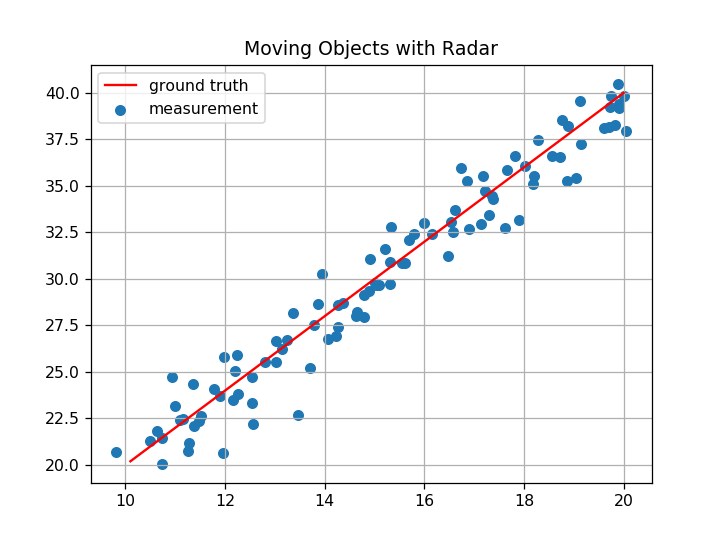

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

sigma_R = np.array([0.6,0.4,0.2,0.2])
dt = 0.1
x_initial  = np.array([10,20,1,2]) 
F = np.matrix([[1,0,dt,0],[0,1,0,dt],[0,0,1,0],[0,0,0,1]])

R = np.diag(sigma_R)
measurements =np.zeros((100,4))
groundT =np.zeros((100,4))

x = x_initial
for i in range(100):
    x = F.dot(x)
    x = (np.squeeze(np.asarray(x)))
    noise = np.random.normal(0, sigma_R, np.shape(sigma_R))
    #x = x+noise
    measurements[i,:] = x +noise
    groundT[i,:] = x
plt.scatter(measurements[:,0], measurements[:,1], label='measurement')
plt.plot(groundT[:,0], groundT[:,1], label='ground truth', color= 'red')

_title = ('Moving Objects with Radar')
plt.title(_title)
plt.grid(True)
plt.legend()

In [2]:
P = np.diag(np.array([1000.,1000., 1000., 1000.]))
P_plot = np.zeros(len(measurements))
x_pred = np.zeros(np.shape(measurements))
H = np.identity(4)
I = np.identity(4)
for index, measure in enumerate(measurements):
    if index ==0 :
        x = np.matrix(measure).T
        
    Z =np.matrix(measure).T
    y = Z-(H.dot(x))
    
    S = H*P*H.transpose()+R
    K = P*H.transpose()*np.linalg.inv(S)
    x = x+(K*y)
    P = (I-K*H)*P
    # prediction
    x = F*x #+u
    P = F*P*F.transpose() 
    P_plot[index] =  np.linalg.det(P) # save determinate of P 
    x_pred[index,:] = x.T
    

<IPython.core.display.Javascript object>


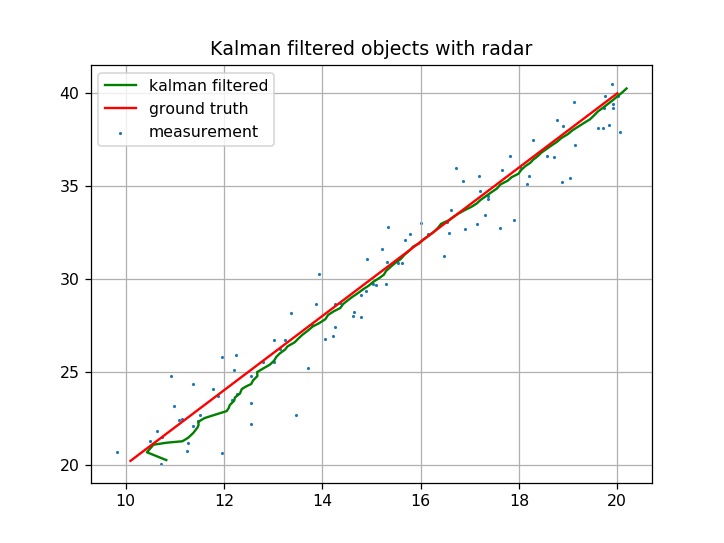

<IPython.core.display.Javascript object>


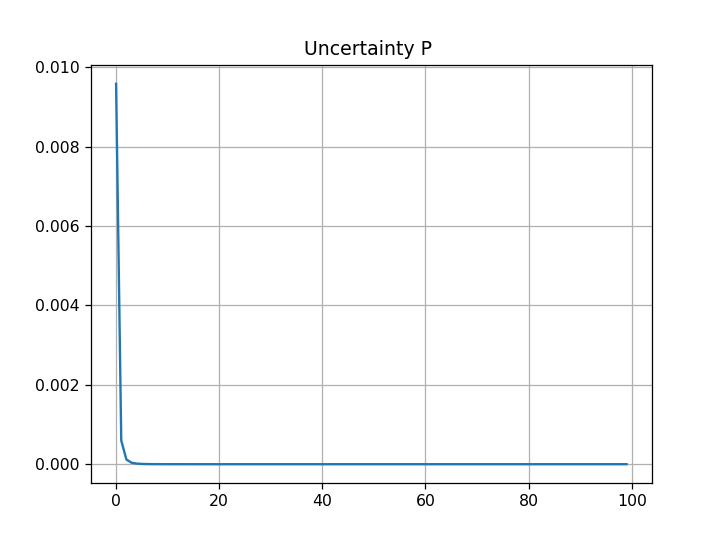

In [4]:
%matplotlib notebook

plt.plot(x_pred[:,0], x_pred[:,1],color = 'green',label= 'kalman filtered')
plt.scatter(measurements[:,0], measurements[:,1],s =1, label='measurement')
plt.plot(groundT[:,0], groundT[:,1], label='ground truth', color= 'red')

_title = ('Kalman filtered objects with radar')
plt.title(_title)
plt.grid(True)
plt.legend()

plt.figure()
plt.plot(P_plot)
plt.title('Uncertainty P ')
plt.grid(True)

### TASK
#### 1. Estimating Parameters:
Modify the filter so that :
- you only receive the information of the object position (no velocity) 
- estimate the objects velocity with the kalman filter and 
- plot the resulting velocity over distance  

In [54]:
P = np.diag(np.array([1000.,1000., 1000., 1000.]))
x_pred = np.zeros(np.shape(measurements))
H = np.zeros((2,4))
H[0,0] = 1
H[1,1] = 1
R = np.matrix([[sigma_R[0],0],[0, sigma_R[1]]])
I = np.identity(4)
for index, measure in enumerate(measurements):
    if index ==0 :
        x = np.matrix(measure).T # initial state
        
    Z =np.matrix(measure[0:2]).T
    y = Z-(H.dot(x))
    
    S = H.dot(P).dot(H.transpose())+R
    K = P.dot(H.transpose()).dot(np.linalg.inv(S))
    x = x+(K*y)
    P = (I-K*H)*P
    # prediction
    x = F*x #+u
    P = F*P*F.transpose() 
    x_pred[index,:] = x.T
    


In [69]:
# Calculate the distance 
x_pred[:,0:2]
sx = np.cumsum(x_pred[:,0])
sy = np.cumsum(x_pred[:,1])
s = np.sqrt(sx**2+sy**2)  
v = np.sqrt(x_pred[:,2]**2 + x_pred[:,3]**2)
v_real = np.ones(len(sx))*np.sqrt(x_initial[2]**2+x_initial[3]**2)

<IPython.core.display.Javascript object>


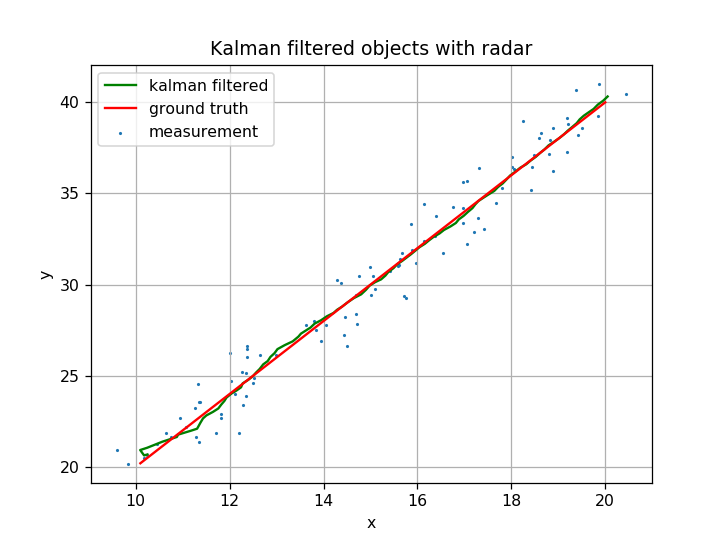

<IPython.core.display.Javascript object>


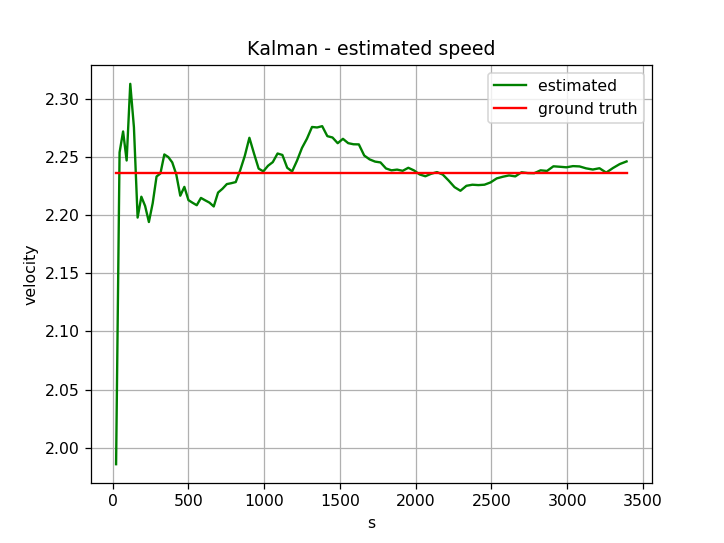

In [71]:
%matplotlib notebook

plt.plot(x_pred[:,0], x_pred[:,1],color = 'green',label= 'kalman filtered')
plt.scatter(measurements[:,0], measurements[:,1],s =1, label='measurement')
plt.plot(groundT[:,0], groundT[:,1], label='ground truth', color= 'red')

_title = ('Kalman filtered objects with radar')
plt.title(_title)
plt.grid(True)
plt.legend()
plt.xlabel('x')
plt.ylabel('y')

# Plot second graph
plt.figure()
plt.plot(s, v,color = 'green',label= 'estimated ')
plt.plot(s, v_real,color = 'red',label= 'ground truth')
plt.xlabel('s')
plt.ylabel('velocity')
_title = ('Kalman - estimated speed')
plt.title(_title)
plt.grid(True)

plt
plt.legend()